## Process an audio

In [32]:
import torchaudio
torchaudio.set_audio_backend("soundfile")


## Normal Speech 
# audio_path = r"C:\Users\amoph\Desktop\speech_therapy\torgo_dataset\MC\MC01\Session1\wav_headMic\0194.wav"
# audio_path = r"E:\speech_data\MC\MC01\Session1\wav_headMic\0194.wav"
# He dressed himself in an ancient black frock coat.
# audio_path = r"E:\speech_data\F\F04\Session1\wav_arrayMic\0025.wav"
# audio_path =  r"C:\Users\amoph\Desktop\speech_therapy\torgo_dataset\F\F04\Session1\wav_arrayMic\0025.wav"
# waveform, sample_rate = torchaudio.load(audio_path)
# waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)  # most models use 16kHz

## Dysarthric Speech
# He dresses himself in an ancient black frock coat.
# audio_path = r"E:\speech_data\M\M02\Session1\wav_headMic\0044.wav"
audio_path = r"C:\Users\amoph\Desktop\speech_therapy\torgo_dataset\M\M02\Session1\wav_headMic\0044.wav"
waveform, sample_rate = torchaudio.load(audio_path)
waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)  # most models use 16kHz



C:\Users\amoph\AppData\Local\Temp\ipykernel_18116\2129351512.py:2: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


## Run through phoneme Model

In [33]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch

processor = Wav2Vec2Processor.from_pretrained("excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k")
model = Wav2Vec2ForCTC.from_pretrained("excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k")

inputs = processor(waveform.squeeze(), sampling_rate=16000, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

probs = torch.nn.functional.softmax(logits, dim=-1)
pred_ids = torch.argmax(probs, dim=-1)
transcription = processor.batch_decode(pred_ids)[0]

# print(f"preds_ids : {pred_ids}")
print(transcription)

framewise_phonemes = pred_ids[0].tolist()
phoneme_tokens = [processor.tokenizer.decode([pid]) for pid in framewise_phonemes]
phoneme_tokens = [p for p in phoneme_tokens if p != ""]
print(phoneme_tokens)

h# hh iy dcl d r eh dcl z ih z ih m z eh l v q ix n eh n ax pau q ey n tcl ch ix n b l aa kcl f r aa kcl k pau k ow tcl tcl t h#
['h#', 'h#', 'hh', 'iy', 'iy', 'dcl', 'dcl', 'dcl', 'd', 'd', 'r', 'eh', 'dcl', 'z', 'z', 'ih', 'z', 'z', 'ih', 'm', 'm', 'z', 'eh', 'l', 'l', 'l', 'v', 'v', 'q', 'q', 'ix', 'n', 'n', 'eh', 'n', 'n', 'ax', 'pau', 'pau', 'q', 'q', 'ey', 'n', 'n', 'tcl', 'tcl', 'ch', 'ch', 'ix', 'n', 'b', 'l', 'aa', 'kcl', 'kcl', 'f', 'f', 'r', 'r', 'r', 'aa', 'kcl', 'kcl', 'kcl', 'k', 'k', 'pau', 'k', 'k', 'ow', 'tcl', 'tcl', 't', 't', 'h#']


## Plot Phoneme against Waveform (Not working properly)

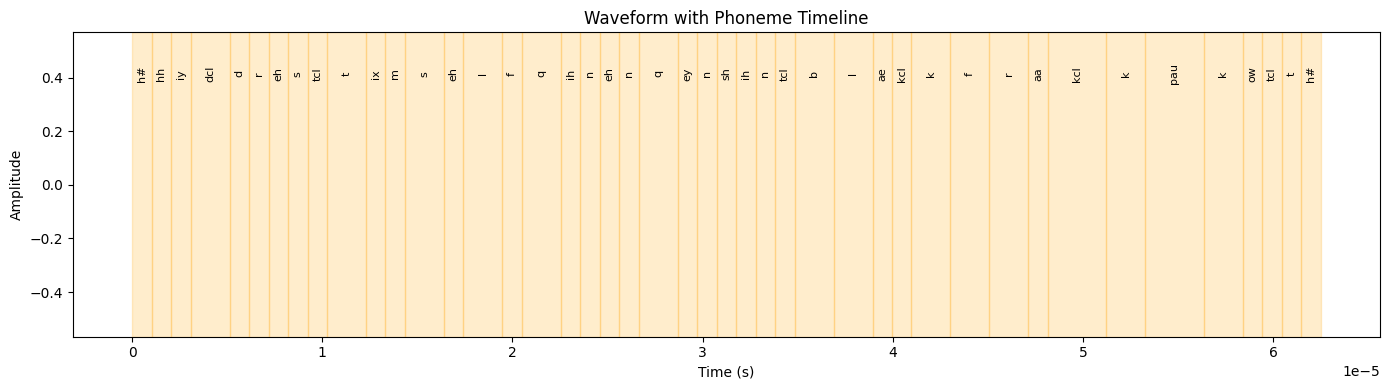

In [13]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

probs = torch.nn.functional.softmax(logits, dim=-1)
pred_ids = torch.argmax(probs, dim=-1)[0]  # Shape: (T,)

# Map ID to phoneme (frame-wise)
vocab = processor.tokenizer.get_vocab()
id2phoneme = {v: k for k, v in vocab.items()}
framewise_phonemes = [id2phoneme[int(pid)] for pid in pred_ids]

def remove_pad_only(phonemes, pad_token="[PAD]"):
    return [p for p in phonemes if p != pad_token]

filtered_phonemes = remove_pad_only(framewise_phonemes)

# ==== Plot 1: Waveform with aligned phoneme timeline ====
def plot_waveform_with_phonemes(waveform, sample_rate, phonemes, num_frames):
    duration = len(waveform) / sample_rate
    times = torch.linspace(0, duration, steps=num_frames)
    frame_duration = duration / num_frames

    # Collapse into segments
    segments = []
    prev_phoneme = phonemes[0]
    start_time = 0.0

    for i, p in enumerate(phonemes):
        t = i * frame_duration
        if p != prev_phoneme:
            segments.append((start_time, t, prev_phoneme))
            start_time = t
            prev_phoneme = p
    segments.append((start_time, duration, prev_phoneme))

    plt.figure(figsize=(14, 4))
    plt.plot(torch.linspace(0, duration, len(waveform)), waveform.numpy())
    for start, end, phoneme in segments:
        plt.axvspan(start, end, color='orange', alpha=0.2)
        plt.text((start + end) / 2, 0.8 * waveform.max().item(), phoneme,
                 ha='center', va='center', fontsize=8, rotation=90)

    plt.title("Waveform with Phoneme Timeline")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

plot_waveform_with_phonemes(waveform, sample_rate, filtered_phonemes, len(filtered_phonemes))


## Plot Phoneme Probabilities (Without [PAD]) against Time

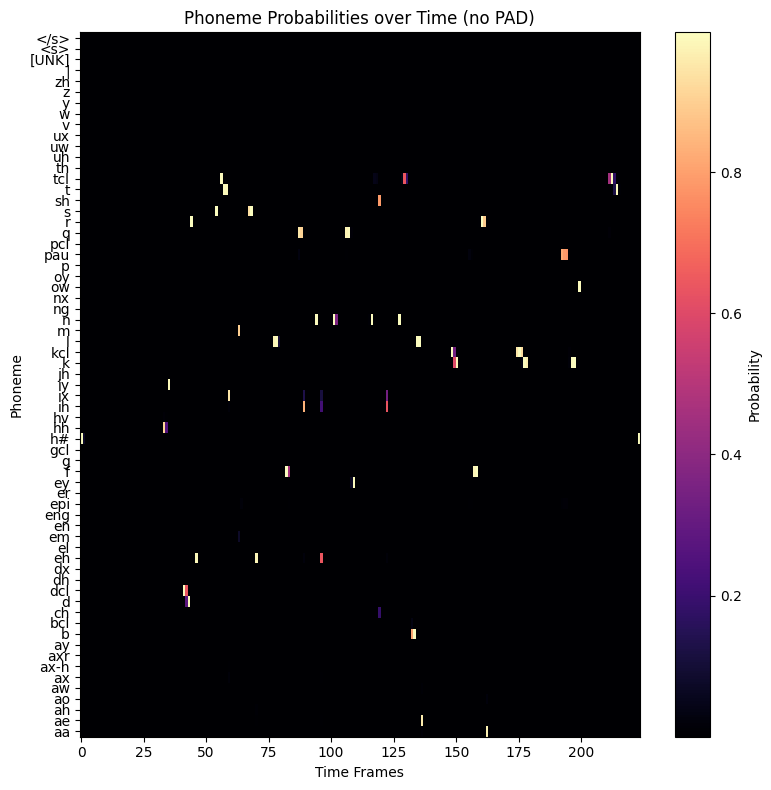

In [14]:
# ==== Plot 2: Phoneme heatmap over time ==== # Without [PAD]
def plot_phoneme_heatmap(probs, id2phoneme, pad_token="[PAD]"):
    import numpy as np

    # Convert tensor to numpy
    probs_np = probs[0].cpu().numpy().T  # Shape: (vocab_size, T)

    # Map IDs to phoneme labels
    phoneme_list_full = [id2phoneme[i] for i in range(probs_np.shape[0])]

    # Filter out pad token
    keep_indices = [i for i, p in enumerate(phoneme_list_full) if p != pad_token] # Maybe can change this to fit what method 1 is doing
    probs_filtered = probs_np[keep_indices, :]
    phoneme_list = [phoneme_list_full[i] for i in keep_indices]

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(probs_filtered, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
    plt.yticks(ticks=range(len(phoneme_list)), labels=phoneme_list)
    plt.colorbar(label='Probability')
    plt.xlabel("Time Frames")
    plt.ylabel("Phoneme")
    plt.title("Phoneme Probabilities over Time (no PAD)")
    plt.tight_layout()
    plt.show()

plot_phoneme_heatmap(probs, id2phoneme)

## Plot Phoneme Probabilities (With [PAD]) against Time

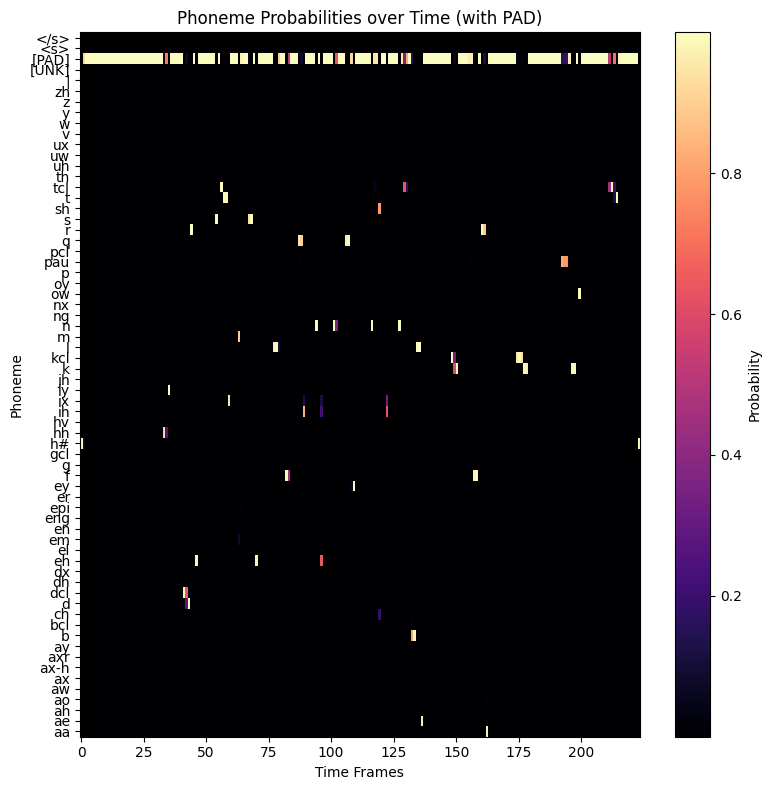

In [15]:
def plot_phoneme_heatmap_with_pad(probs, id2phoneme):
    import numpy as np
    import matplotlib.pyplot as plt

    # Convert tensor to numpy and transpose for heatmap
    probs_np = probs[0].cpu().numpy().T  # Shape: (vocab_size, T)

    # Map IDs to phoneme labels
    phoneme_list = [id2phoneme[i] for i in range(probs_np.shape[0])]

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(probs_np, aspect='auto', origin='lower', cmap='magma', interpolation='nearest')
    plt.yticks(ticks=range(len(phoneme_list)), labels=phoneme_list)
    plt.colorbar(label='Probability')
    plt.xlabel("Time Frames")
    plt.ylabel("Phoneme")
    plt.title("Phoneme Probabilities over Time (with PAD)")
    plt.tight_layout()
    plt.show()

plot_phoneme_heatmap_with_pad(probs, id2phoneme)


## Plot second highest possibility for frames where [PAD] was the highest

Average 2nd-best confidence when [PAD] is top: 0.0144
Average 2nd-best confidence (≥ 0.08) when [PAD] is top: 0.2831
Filtered out 156 low-confidence frames.


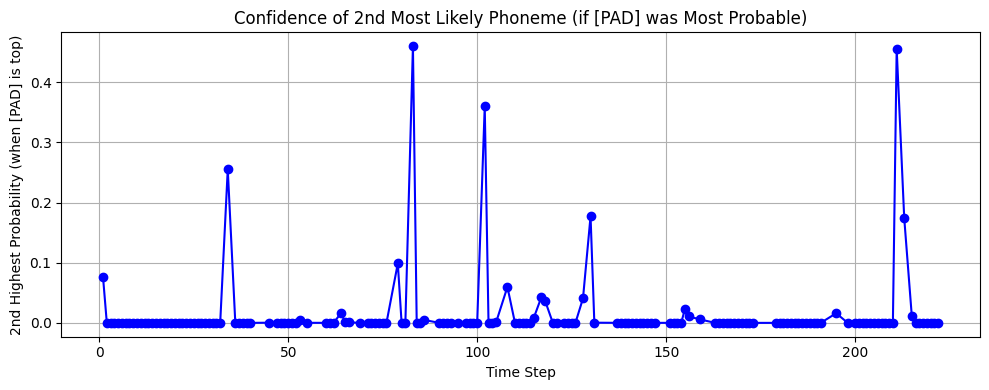

Average 2nd-best confidence when [PAD] is top: 0.0157
Average 2nd-best confidence (≥ 0.08) when [PAD] is top: 0.2170
Filtered out 404 low-confidence frames.


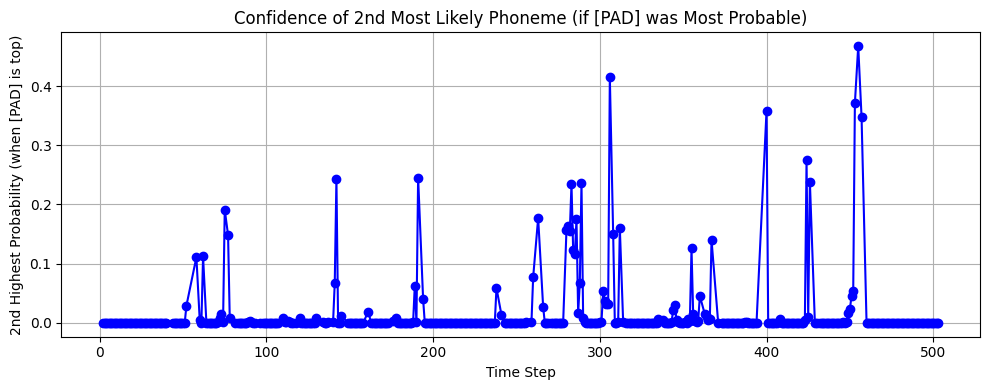

In [30]:
import torch
import matplotlib.pyplot as plt

def plot_second_best_if_pad_top(probs, pad_id):
    """
    Plots the second highest probability per frame only when [PAD] is the highest.
    Also prints the average confidence of these second-best predictions.
    
    Args:
        probs (torch.Tensor): shape (1, T, V) = (batch, time, vocab_size)
        pad_id (int): ID of the [PAD] token
    """
    # Remove batch dimension
    probs = probs.squeeze(0)  # shape: (T, V)

    second_highest_probs = []
    frame_indices = []

    for t, frame_probs in enumerate(probs):  # frame_probs: (V,)
        top2 = torch.topk(frame_probs, k=2)
        top_ids = top2.indices
        top_vals = top2.values

        # If [PAD] is the top predicted phoneme
        if top_ids[0].item() == pad_id:
            second_highest_probs.append(top_vals[1].item())  # 2nd best
            frame_indices.append(t)  # record frame index

    # Compute and print average of these second-best values
    if second_highest_probs:
        avg_conf = sum(second_highest_probs) / len(second_highest_probs)
        print(f"Average 2nd-best confidence when [PAD] is top: {avg_conf:.4f}")
    else:
        print("No frames where [PAD] was the top prediction.")

    # Values below this threshold means [PAD] probability was extremely high, means very likely it was just silence/not the start of a phoneme
    threshold = 0.08
    # Filter out low-confidence values
    filtered_vals = [v for v in second_highest_probs if v >= threshold]
    # Compute and print average of these second-best values (above threshold)
    if filtered_vals:
        avg_conf = sum(filtered_vals) / len(filtered_vals)
        print(f"Average 2nd-best confidence (≥ {threshold}) when [PAD] is top: {avg_conf:.4f}")
        print(f"Filtered out {len(second_highest_probs) - len(filtered_vals)} low-confidence frames.")
    else:
        print(f"No valid 2nd-best predictions ≥ {threshold} when [PAD] was top.")


    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(frame_indices, second_highest_probs, marker='o', linestyle='-', color='blue')
    plt.xlabel("Time Step")
    plt.ylabel("2nd Highest Probability (when [PAD] is top)")
    plt.title("Confidence of 2nd Most Likely Phoneme (if [PAD] was Most Probable)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Non-dysarthric
pad_id = processor.tokenizer.convert_tokens_to_ids("[PAD]")
plot_second_best_if_pad_top(probs, pad_id)

# Dysarthric
plot_second_best_if_pad_top(probs2, pad_id)

## Experimenting on three methods of [PAD] masking

In [41]:
# Method 1  ==== Worse ==== # Too many probabilities near 0, causes a longer audio to naturally have a lower conf
# # Step 2: Get PAD token ID
# pad_token = "[PAD]"
# pad_id = processor.tokenizer.convert_tokens_to_ids(pad_token)

# # Step 3: Mask out PAD token
# probs_no_pad = probs.clone()
# probs_no_pad[..., pad_id] = 0.0  # set [PAD] probability to 0

# # Step 4: Get max prob per time step (ignoring PAD)
# framewise_confidence = probs_no_pad.max(dim=-1).values  # shape: (1, T)

# # Step 5: Compute average confidence
# mean_confidence = framewise_confidence.mean().item()

# print(f"Mean phoneme confidence (excluding [PAD]): {mean_confidence:.4f}")

# Method 2  ==== Worse ==== Might be worse because for slurred speech, model might predict [PAD] alot, so we end up ignoring basically the whole speech except for very clear articulation which may artifically inflate average phoneme score
# Step 1: Get **index** of most likely token for each frame
# pred_ids = torch.argmax(probs, dim=-1)

# # Step 2: Create a mask for non-PAD frames
# non_pad_mask = pred_ids != pad_id  # shape: (1, T) # Basically select only the frames where [PAD] was not predicted (from argmax)

# # Step 3: Get max prob for each frame
# probs_no_pad = probs.clone()
# framewise_confidence = probs_no_pad.max(dim=-1).values  # shape: (1, T)

# # Step 4: Use mask to exclude PAD frames
# framewise_confidence = framewise_confidence[non_pad_mask]

# # Step 5: Compute mean over non-PAD frames only
# mean_confidence = framewise_confidence.mean().item()

# print(f"Mean phoneme confidence (excluding [PAD]): {mean_confidence:.4f}")

# Method 3
# === Step 1: Get PAD token ID ===
pad_token = "[PAD]"
pad_id = processor.tokenizer.convert_tokens_to_ids(pad_token)

def create_pad_mask_method_3(probs, pad_id, threshold = 0.08):
    # === Step 2: Clone original probabilities ===
    probs_no_pad = probs.clone()
    probs_no_pad[..., pad_id] = 0.0  # Temporarily zero out PAD to ignore it in max()

    # === Step 3: Get confidence per frame (ignoring PAD) ===
    framewise_confidence = probs_no_pad.max(dim=-1).values  # shape: (1, T)

    # === Step 4: Apply threshold-based filtering ===
    original_preds = torch.argmax(probs, dim=-1)  # Best phoneme per frame (with PAD included)
    topk_vals, _ = torch.topk(probs, k=2, dim=-1)  # Get top 2 values for each frame

    # Get mask where [PAD] was the top prediction
    pad_is_top = (original_preds == pad_id)

    # Get the second-best values in those frames
    second_best_vals = topk_vals[..., 1]  # shape: (1, T)

    # Build final mask: keep frame if:
    # - [PAD] was NOT top, OR
    # - [PAD] was top, but second-best confidence >= threshold
    threshold = 0.08
    valid_mask = (~pad_is_top) | (second_best_vals >= threshold)

    # Apply mask
    filtered_confidences = framewise_confidence[valid_mask]

    # === Step 5: Compute average ===
    if filtered_confidences.numel() > 0:
        mean_confidence = filtered_confidences.mean().item()
        std_confidence = filtered_confidences.std().item()
    else:
        mean_confidence = float("nan")  # or 0.0 or another sentinel value
    
    return mean_confidence, std_confidence

mean_confidence, _ = create_pad_mask_method_3(probs, pad_id)
if mean_confidence:
    print(f"Mean phoneme confidence (excluding [PAD], and low second-best): {mean_confidence:.4f}")

Mean phoneme confidence (excluding [PAD], and low second-best): 0.6807


## Full script to extract mean confidence values of Youtube Videos

100%|██████████| 527/527 [18:51<00:00,  2.15s/it]


<Figure size 800x600 with 0 Axes>

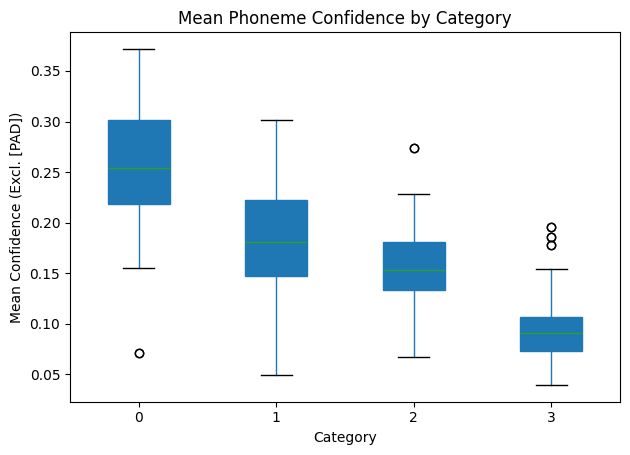


Mean Confidence per Category:
category
0    0.259415
1    0.183704
2    0.155777
3    0.097977
Name: mean_confidence, dtype: float64


<Figure size 800x600 with 0 Axes>

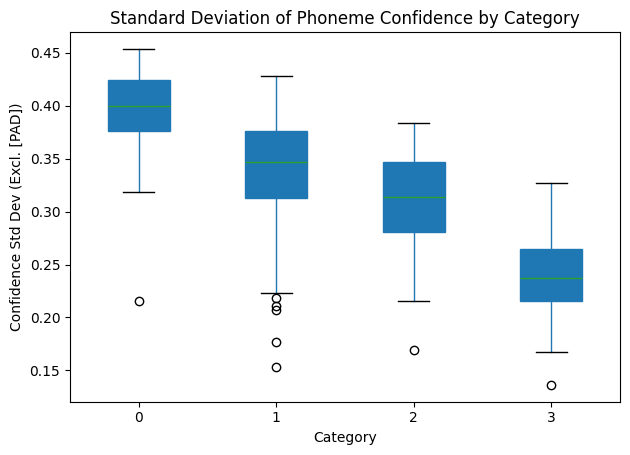


Mean of Confidence Std Dev per Category:
category
0    0.396444
1    0.342148
2    0.308632
3    0.238087
Name: std_confidence, dtype: float64


In [ ]:
import pandas as pd
import torchaudio
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load phoneme model + processor
processor = Wav2Vec2Processor.from_pretrained(
    "excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k"
).eval()

# Load CSV
csv_path = r"C:\Users\YIDAN\Desktop\projects\dysarthria\dataset_youtube_all_splits.csv"
df = pd.read_csv(csv_path)

# Convert category column to string if needed
df["category"] = df["category"].astype(str)

TARGET_SR = 16000

# Get PAD token ID
pad_token = "[PAD]"
pad_id = processor.tokenizer.convert_tokens_to_ids(pad_token)

# Store results here
results = []

for _, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = row["path"]
    category = row["category"]
    patient_id = row["patient_id"]

    try:
        # Load and process audio
        waveform, sr = torchaudio.load(audio_path)
        waveform = waveform.squeeze()
        inputs = processor(waveform, sampling_rate=TARGET_SR, return_tensors="pt")

        # Inference
        with torch.no_grad():
            logits = model(**inputs).logits  # (1, T, vocab)
        probs = torch.nn.functional.softmax(logits, dim=-1)

        # Method 1  === Worse === # Too many probabilities near 0, causes a longer audio to naturally have a lower conf
        # probs[..., pad_id] = 0.0  # Remove PAD token from consideration 
        # framewise_confidence = probs.max(dim=-1).values  # top-1 probability per frame
        
        # Method 3
        mean_conf, std_conf = create_pad_mask_method_3(probs, pad_id)

        results.append({
            "patient_id": patient_id,
            "category": category,
            "mean_confidence": mean_conf,
            "std_confidence": std_conf
        })

        results.append({"category": category, "mean_confidence": mean_conf})

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        continue

# Create DataFrame of results
result_df = pd.DataFrame(results)

# === Boxplot ===
plt.figure(figsize=(8, 6))
box = result_df.boxplot(by="category", column=["mean_confidence"], grid=False, patch_artist=True)
colors = ["lightblue", "lightgreen", "lightcoral", "violet"]
for patch, color in zip(box.artists, colors):
    patch.set_facecolor(color)

plt.title("Mean Phoneme Confidence by Category")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Mean Confidence (Excl. [PAD])")
plt.tight_layout()
plt.show()

# === Print category-wise means ===
category_means = result_df.groupby("category")["mean_confidence"].mean()
print("\nMean Confidence per Category:")
print(category_means)

# === Std Deviation Boxplot ===
plt.figure(figsize=(8, 6))
box = result_df.boxplot(by="category", column=["std_confidence"], grid=False, patch_artist=True)
colors = ["lightblue", "lightgreen", "lightcoral", "violet"]
for patch, color in zip(box.artists, colors):
    patch.set_facecolor(color)

plt.title("Standard Deviation of Phoneme Confidence by Category")
plt.suptitle("")
plt.xlabel("Category")
plt.ylabel("Confidence Std Dev (Excl. [PAD])")
plt.tight_layout()
plt.show()

# === Print category-wise std dev means ===
category_std_means = result_df.groupby("category")["std_confidence"].mean()
print("\nMean of Confidence Std Dev per Category:")
print(category_std_means)

In [ ]:
#result_df.to_csv("confidence_stats_per_clip_method_3.csv", index=False)


## Code to plot per patient phoneme confidence

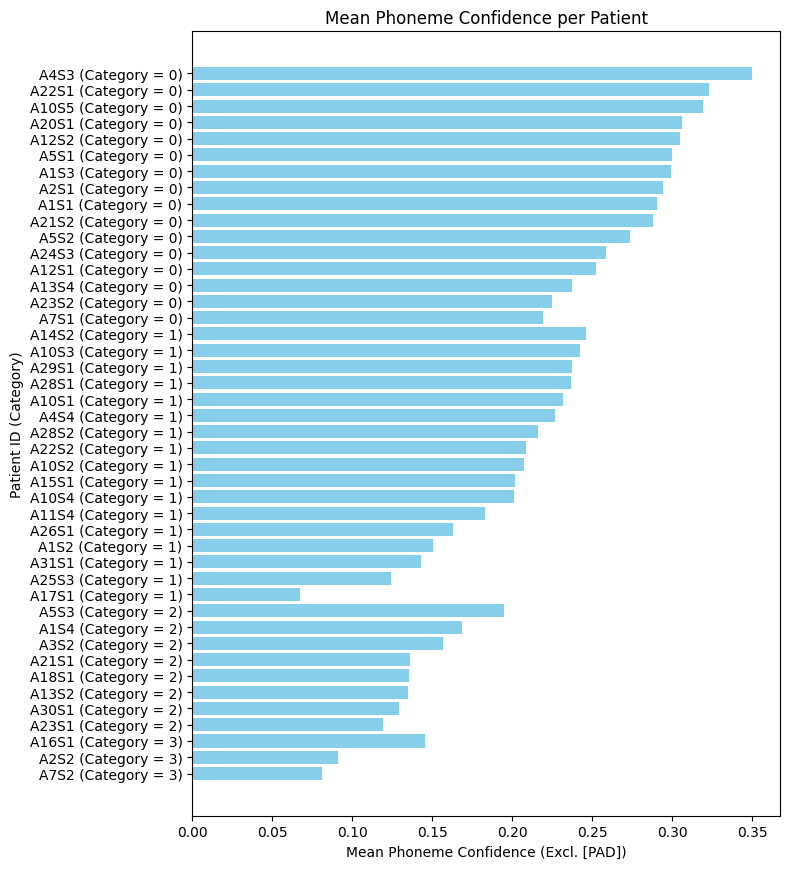

In [38]:
import matplotlib.pyplot as plt

# Group by patient ID and category
patient_stats = (
    result_df.groupby("patient_id")
    .agg(mean_confidence=("mean_confidence", "mean"), category=("category", "first"))
    .reset_index()
)

# Create a label column: "A1S1 (Category = 0)"
patient_stats["label"] = patient_stats.apply(
    lambda row: f"{row['patient_id']} (Category = {row['category']})", axis=1
)

# Sort by category first, then by confidence
patient_stats = patient_stats.sort_values(by=["category", "mean_confidence"], ascending=[True, False])

# Plot horizontal bar chart
plt.figure(figsize=(8, len(patient_stats) * 0.2))
bars = plt.barh(patient_stats["label"], patient_stats["mean_confidence"], color="skyblue")

plt.xlabel("Mean Phoneme Confidence (Excl. [PAD])")
plt.ylabel("Patient ID (Category)")
plt.title("Mean Phoneme Confidence per Patient")
plt.tight_layout()
plt.gca().invert_yaxis()  # Most confident at the top
plt.show()


## Script to get Average Phoneme Confidence for 1 Audio Sample

In [24]:
import pandas as pd
import torchaudio
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

# Load phoneme model + processor
processor = Wav2Vec2Processor.from_pretrained(
    "excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k"
)
model = Wav2Vec2ForCTC.from_pretrained(
    "excalibur12/wav2vec2-large-lv60_phoneme-timit_english_timit-4k"
).eval()

# Get PAD token ID
pad_token = "[PAD]"
pad_id = processor.tokenizer.convert_tokens_to_ids(pad_token)

# Process Audio
# audio_path = r"E:\labelled_speech\YouTube Audio\diarization outputs filtered\audio 14\speaker 2 mild\segments _=2s\segment 6.wav"
# audio_path = r"E:\labelled_speech\YouTube Audio\diarization outputs filtered\audio 17\speaker 1 mild\segments _=2s\segment 3.wav"
# audio_path = r"E:\labelled_speech\YouTube Audio\diarization outputs filtered\audio 16\speaker 1 sev\segments _=2s\segment 1 chunk 2.wav"
# audio_path = r"E:\labelled_speech\YouTube Audio\diarization outputs filtered\audio 7\speaker 2 sev\segments _=2s\segment 9.wav"
# audio_path = r"E:\labelled_speech\YouTube Audio\diarization outputs filtered\audio 5\speaker 3 mod\segments _=2s\segment 37.wav"
audio_path = r"E:\labelled_speech\YouTube Audio\diarization outputs filtered\audio 23\speaker 1 mod\segments _=2s\segment 4.wav"

## Non-Dysarthric Speech
audio_path =  r"C:\Users\amoph\Desktop\speech_therapy\torgo_dataset\F\F04\Session1\wav_arrayMic\0025.wav"
## Dysarthric Speech
# He dresses himself in an ancient black frock coat.
# audio_path = r"C:\Users\amoph\Desktop\speech_therapy\torgo_dataset\M\M02\Session1\wav_headMic\0044.wav"

waveform, sample_rate = torchaudio.load(audio_path)
waveform = torchaudio.functional.resample(waveform, sample_rate, 16000)  # most models use 16kHz

#inputs = processor(waveform, sampling_rate=TARGET_SR, return_tensors="pt")
inputs = processor(waveform.squeeze(), sampling_rate=16000, return_tensors="pt")

# Inference
with torch.no_grad():
    logits = model(**inputs).logits  # (1, T, vocab)
probs = torch.nn.functional.softmax(logits, dim=-1)

# Remove PAD token from consideration # Method 1
probs[..., pad_id] = 0.0  # mask PAD
framewise_confidence = probs.max(dim=-1).values  # top-1 probability per frame

mean_conf = framewise_confidence.mean().item()

print(f"Mean phoneme confidence (excluding [PAD]): {mean_conf:.4f}")

Mean phoneme confidence (excluding [PAD]): 0.2645
